# Direct imaging of exoplanets

Simple example of direct exoplanet imaging.


In [2]:
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import scipy

from nopt.transforms import *
from nopt.constraints import *
from nopt.problems import *
from nopt.solvers import *
import pylops

import vip_hci as vip
from hciplot import plot_frames, plot_cubes

### Prepare data

The variable ``dataset`` contains a Betapic of size (612, 100, 100) where the first dimension is time and the other two are the spatial dimensions.  

We erase the star with the radius of 7 pixels around the center. The planet is located around $(61,61)$ pixel.

In [3]:
ROOT_PATH = '/home/vary/src/pynopt/'

def load_adi_dataset(adi_cube, psf, psf_size=None):
    adi_cube = os.path.join(ROOT_PATH, adi_cube)
    print(adi_cube)
    psf = os.path.join(ROOT_PATH, psf)
    dataset = vip.hci_dataset.Dataset(
        cube=vip.fits.open_fits(adi_cube,n=0, verbose=False),
        angles=vip.fits.open_fits(adi_cube,n=1, verbose=False),
        psf=vip.fits.open_fits(psf,verbose=False)
    )
    # Normalize PSF
    dataset.normalize_psf(verbose=False, size=psf_size)
    dataset.planets = []
    dataset.px_scale = 0.
    return dataset

def bpic_naco():
    dataset = load_adi_dataset(
        "data/bpic_naco",
        "data/naco_psf",
        psf_size=21
    )
    dataset.recenter(negative=True, plot=False, verbose=False)
    dataset.planets = [
        (16.26, 45.0)
    ]
    return dataset

def bpic_naco_empty():
    dataset = load_adi_dataset(
        "/home/vary/src/pynopt/data/bpic_naco_empty",
        "/home/vary/src/pynopt/data/naco_psf",
        psf_size=21
    )
    dataset.angles = -dataset.angles
    dataset.recenter(negative=True, plot=False)
    return dataset

def sphere_k1_51eri_2016():
    dataset = load_adi_dataset(
        "data/sphere_k1_51eri_2016",
        "data/sphere_k1_51eri_2016_psf",
        psf_size=21
    )
    dataset.planets = [
        (37.26, -101.6)
    ]
    return dataset

def sphere_k1_51eri_2016_empty():
    dataset = vip.hci_dataset.Dataset(
        cube=vip.fits.open_fits("/home/vary/src/pynopt/data/sphere_k1_51eri_2016_empty"),
        angles=vip.fits.open_fits("/home/vary/src/pynopt/data/sphere_k1_51eri_2016",n=1),
        psf=vip.fits.open_fits("/home/vary/src/pynopt/data/sphere_k1_51eri_2016_psf")
    )
    psf_size=21
    
    dataset.angles = dataset.angles
    # Normalize PSF
    dataset.normalize_psf(verbose=False, size=psf_size)
    dataset.planets = []
    dataset.px_scale = 0.
    return dataset

def cart2rad(y, x):
    """Converts cartesian position (y, x) to radial position (rad, theta)"""
    import numpy as np
    sqrtxy = np.sqrt(y*y + x*x)
    atan = np.rad2deg(np.arctan2(y, x))
    return sqrtxy, atan 


def rad2cart(rad, theta):
    """Converts radial position (rad, theta) to cartesian position (y, x)"""
    return rad * np.sin(np.deg2rad(theta)), rad * np.cos(np.deg2rad(theta))

In [55]:
real_planet=True

if real_planet:
    dataset = sphere_k1_51eri_2016()
    dataset.crop_frames(100)
    location = (-36.49+49.5,-7.49+49.5)
    cubefc = dataset.cube
else:
    dataset = sphere_k1_51eri_2016_empty()
    flux = 144*2#144*3 #datset.cube[:,location_rad[0], location_rad[1]]*2
    #cube_emp = cube_planet_free(plpar_bpicb, cubefc, angs, psfn, pxscale_naco)
    #rad2cart
    dataset.crop_frames(100)
    from vip_hci.fm.fakecomp import cube_inject_companions
    cubefc, location = cube_inject_companions(dataset.cube, dataset.psfn, dataset.angles, flevel=flux, rad_dists=3*dataset.fwhm, plsc=0.02727, n_branches = 1, theta = 50, verbose=True, full_output=True)
    print(np.max(flux*dataset.psfn))

/home/vary/src/pynopt/data/sphere_k1_51eri_2016
Cube array shape: (256, 200, 200)
Angles array shape: (256,)
PSF array shape: (50, 50)
Normalized PSF array shape: (21, 21)
The attribute `psfn` contains the normalized PSF
`fwhm` attribute set to
4.863
New shape: (256, 100, 100)


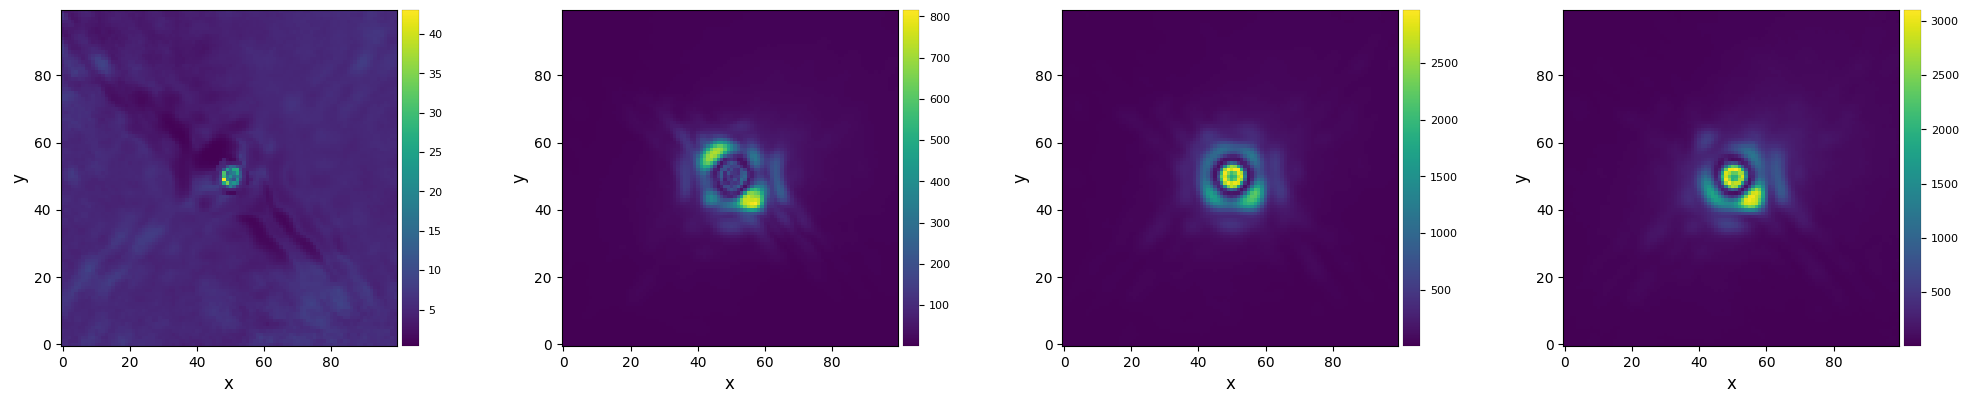

In [109]:
def norm_cube(cube):
    mean_frame = cube.mean(axis=0)
    stdev_frame = cube.std(axis=0)
    cube_normed = (cube) / stdev_frame
    return (cube_normed, mean_frame, stdev_frame)
cube_normed, mean_frame, stdev_frame = norm_cube(cubefc)
plot_frames((cube_normed[10],stdev_frame, mean_frame, dataset.cube[10]))

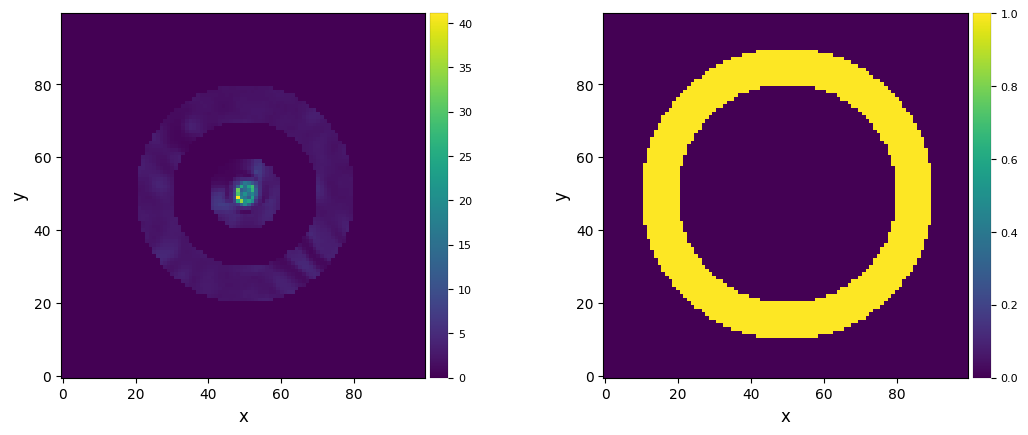

In [92]:
cube = cube_normed # dataset.cube
cy, cx = vip.var.frame_center(cube)
psfn = dataset.psfn
angles = dataset.angles
planets = dataset.planets

def create_annular_regions(cube_shape, r_in, r_out, r_by, center):
    cx, cy = center
    x = np.arange(0, cube_shape[2])
    y = np.arange(0, cube_shape[1])
    annular_regions_frame = []
    annular_regions_cube = []
    for r in range(r_in, r_out, r_by):
        mask_out = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 >= r**2
        mask_in = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < (r+r_by)**2
        annular_regions_frame.append((mask_in*mask_out).flatten())
        annular_regions_cube.append(np.tile(mask_in*mask_out,(cube_shape[0],1,1)).flatten())
    return annular_regions_frame, annular_regions_cube

annular_regions_frame, annular_regions_cube = create_annular_regions(cube.shape, 0, 50, 10, (cx, cy))
ind_example = (annular_regions_cube[0] + annular_regions_cube[2]).reshape(cube.shape)
plot_frames(((cube*ind_example)[40], annular_regions_frame[3].reshape(cube.shape[-2:])))

ind_all = np.array(annular_regions_cube).sum(axis=0)
cube = (cube.flatten() * ind_all).reshape(cube.shape)

### PSF of the star / convolution kernel
Prepare kernel for detecting the star. We crop only the central part of the kernel to have a 9x9 filter that we will use for detection

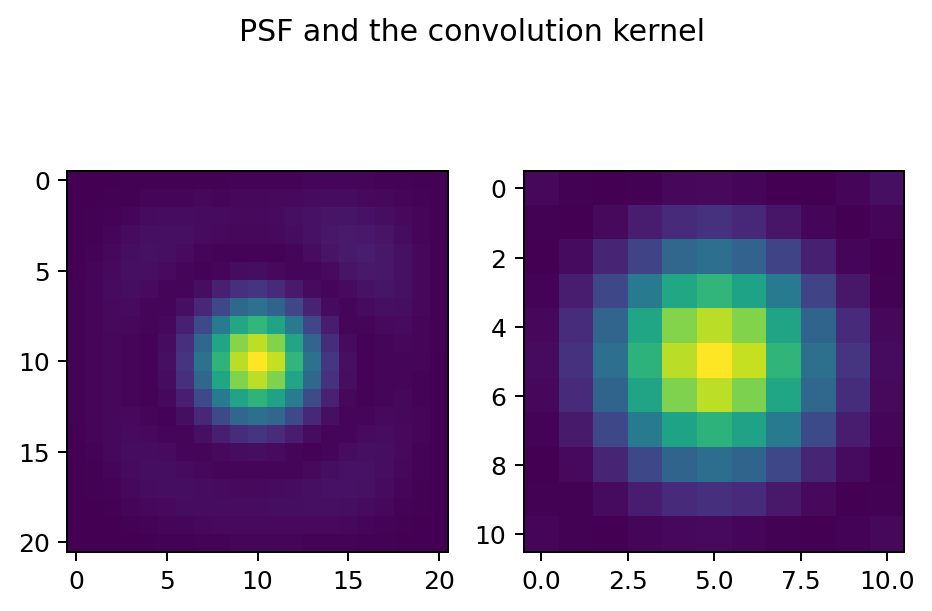

In [93]:
cx = psfn.shape[0] // 2 + 1
cy = psfn.shape[1] // 2 + 1
rx = 6
ry = 6
kernel = psfn[cy-ry:cy+ry-1,cx-rx:cx+rx-1]
kernel_norm = np.linalg.norm(kernel,ord = 'fro')
kernel_normed = kernel / kernel_norm

fig, axs = plt.subplots(1,2, dpi=180)
fig.suptitle('PSF and the convolution kernel')
plt1 = axs[0].imshow(psfn)
plt2 = axs[1].imshow(kernel_normed)
fig.show()

### Recovery model

We assume the following model:

$ X = L + \Psi(c)$

where $\mathrm{rank}(L)\leq r$, $\|c\|_0 \leq s$, and $\Psi: R^{N^2} :\rightarrow R^{T N^2}$ is a linear transform based on a 2D convolution I will refer to as __trajectorlet__. 

The adjoint transform of $\Psi^*(X)$ is performed to a vector with $(TN^2)$ entries as follows:

1. First derotate the reshaped cube (T, N, N) based on the given angles
2. Then sum over the first dimension $T$ to get a matrix of $(N,N)$
3. Perform 2D convolution on the $(N,N)$ matrix using the PSF kernel and output a vectorized output with $N^2$ elements

The entries that have large coefficients denote which of the $N^2$ locations the planet trajectory likely starts at.

Similiarly, the forward operation is performed to a vector of size $N^2$ entries as follows:

1. First reshape the vector to an $(N,N)$ matrix and deconvolve using the same kernel resulting into an $(N, N)$ matrix
2. Reshape the matrix into an $N^2$ vector and copy it $T$ times to create a matrix of $(T, N^2)$
3. Perform derotation on the reshaped cube $(T, N, N)$ and return a vector with $(T N^2)$ entries

For a kernel (9, 9) whose Frobenius norm is equal to 1, this produces a tight frame operation.

In [94]:
from pylops import LinearOperator
class Trajectorlet(LinearOperator):
    def __init__(self, shape, kernel, angles, dtype=None, *args, **kwargs):
        '''
            Params:
                - shape (the dimensions of the data cube)
                - kernel (the psf kernel for convolution)
                - angles (list of rotated angles)
        '''
        self._shape_cube = shape
        self.shape = (np.prod(self._shape_cube), np.prod(self._shape_cube[-2:]))
        self.dtype = dtype
        super().__init__(dtype, self.shape, *args, **kwargs)
        self._kernel = kernel
        self._angles = angles
        self._conv2d = pylops.signalprocessing.Convolve2D(
            N = np.prod(self._shape_cube[-2:]),
            dims=self._shape_cube[-2:],
            h=self._kernel,
            offset = (self._kernel.shape[0]//2+1, self._kernel.shape[1]//2+1)
        )

    def _matvec(self, x): # Forward operation \Psi(c)
       y = self._conv2d.matvec(x)
       cube_out = np.tile(y, (self._shape_cube[0], 1))
       cube_der = vip.preproc.cube_derotate(cube_out.reshape(self._shape_cube), -self._angles, imlib='opencv')
       return cube_der.flatten() # reshape(self._shape_cube[0],-1)

    def _rmatvec(self, y): # Adjoint operation \Psi^T(y)
        der_cube = vip.preproc.cube_derotate(y.reshape(self._shape_cube), self._angles, imlib='opencv')
        x = self._conv2d.rmatvec(der_cube.sum(axis=0).flatten())
        return x

### NAHT 

We solve the following minimization problem using NAHT algorithm (Algorithm 2 [arxiv](https://arxiv.org/pdf/2007.09457.pdf))

$$\min_{L\in \mathbb{R}^{m\times n},\,c\in\mathbb{R}^{n}} \| b - L - \Psi(c) \|_F^2, \qquad \mathrm{s.t.}\, \mathrm{rank}(L)\leq r,\quad \|c\|_0\leq s$$

where where $m = T$ and $n = N^2$ for a matrix format of the image sequence of $N\times N$ images in $T$ times. 

In [95]:
m = cube.shape[0]
n = np.prod(cube.shape[-2:])

r = 5
rb = 10
s = 1

HTr = FixedRank(r, (m,n))
#HTrb = BlockFixedRank(annular_regions_frame, rb, (m,n))
HTs = Euclidean()# 
constraints = (HTr, HTs)

# Prepare transform
trajectorlet = Trajectorlet(cube.shape, kernel_normed/m**(1/2), angles)
As = (None, trajectorlet)
b = cube.flatten()

In [11]:
cube_empty_normed, _, _= norm_cube(dataset.cube)

In [12]:
_,s1,_ = np.linalg.svd((cube_empty_normed).reshape(m,n), full_matrices = False)
_,s2,_ = np.linalg.svd((cube_normed).reshape(m,n), full_matrices = False)
plt.plot(s1[0:20])
plt.plot(s2[0:20])

In [24]:
x0 = [None, None]
_, x0[0] = constraints[0].project(b)
w = scipy.sparse.linalg.lsqr(trajectorlet, x0[0] - b, 
                show=False, iter_lim=50)[0]
_,x0[1] = constraints[1].project(w)

In [ ]:
x0 = [None, None]
w = scipy.sparse.linalg.lsqr(trajectorlet, b, 
                show=False, iter_lim=50)[0]
_,x0[1] = constraints[1].project(w)
_, x0[0] = constraints[0].project(trajectorlet.matvec(x0[1])-b)

In [96]:
problem = LinearProblemSum(As, b, constraints)
solver = NAHT(logverbosity = 2, maxiter = 30, verbosity = 2, maxtime=2*60, minreldecrease = 1-1e-3)

In [97]:
# This can take a while
x, opt_log = solver.solve(problem) #x = x0

 iter		   obj. value	    grad. norm
    1	+1.4818855726369968e+05	2.41196654e+02
    2	+1.4793821450786415e+05	2.15281330e+02
    3	+1.4793362834878755e+05	2.13963575e+02
    4	+1.4793243972477393e+05	2.13423529e+02
    5	+1.4793213124528941e+05	2.13182837e+02
    6	+1.4793205098424712e+05	2.13069237e+02
    7	+1.4793202999550969e+05	2.13013736e+02
    8	+1.4793202445441179e+05	2.12986094e+02
    9	+1.4793202296488150e+05	2.12972185e+02
   10	+1.4793202255089235e+05	2.12965148e+02
   11	+1.4793202243202127e+05	2.12961578e+02
   12	+1.4793202239044072e+05	2.12959765e+02
   13	+1.4793202237706864e+05	2.12958843e+02
   14	+1.4793202237180853e+05	2.12958374e+02
   15	+1.4793202236983701e+05	2.12958136e+02
   16	+1.4793202236698990e+05	2.12958015e+02
Terminated - min relative decrease reached after 16 iterations, 14.27 seconds.



In [102]:
def exoplanet_lrpt(cube, angle_list, r=20, s=10, prad=1, MAX_ITER=30, fwhm=4, asize= 4, psfn = None):
    '''Exoplanet low-rank plus trajectory'''

    m = cube.shape[0]
    n = np.prod(cube.shape[-2:])

    # Prepare constraints
    HTr = FixedRank(r, (m,n))
    HTs = PositiveSparsity(s) # Euclidean()# 
    constraints = (HTr, HTs)

    # Prepare transforms
    kernel = psfn / np.linalg.norm(psfn)
    trajectorlet = Trajectorlet(cube.shape, kernel/m**(1/2), angle_list)
    As = (None, trajectorlet)

    b = cube.flatten()

    # Define the problem and solver
    problem = LinearProblemSum(As, b, (HTr, HTs))
    solver = NAHT(logverbosity = 2, verbosity =2, maxiter = MAX_ITER)

    # Solve
    x, opt_log = solver.solve(problem)

    return (x, opt_log)

In [103]:
x, opt = exoplanet_lrpt(cube, angles, r=10, s=15, prad=1, MAX_ITER=30, fwhm=4, asize= 4, psfn = psfn)

 iter		   obj. value	    grad. norm
    1	+7.6192944213329887e+04	1.44967929e+02
    2	+7.5838881471871849e+04	1.21366855e+02
    3	+7.5670593347407848e+04	9.44736189e+01
    4	+7.5661825618207658e+04	8.60204736e+01
    5	+7.5600700553901363e+04	8.34780840e+01
    6	+7.5599146469749423e+04	8.32238581e+01
    7	+7.5598483109344583e+04	8.31210197e+01
    8	+7.5598174380303739e+04	8.30790295e+01
    9	+7.5597988613734124e+04	8.30605431e+01
   10	+7.6756714961212492e+04	8.30515685e+01
   11	+7.5727306037940449e+04	1.00052215e+02
   12	+7.5697537593750400e+04	9.62857128e+01
   13	+7.5685069705830523e+04	9.48881349e+01
   14	+7.5666490046421502e+04	9.43687861e+01
   15	+7.7439843939046987e+04	9.28296467e+01
   16	+7.5759944533087910e+04	1.05456475e+02
Terminated - min relative decrease reached after 16 iterations, 15.33 seconds.



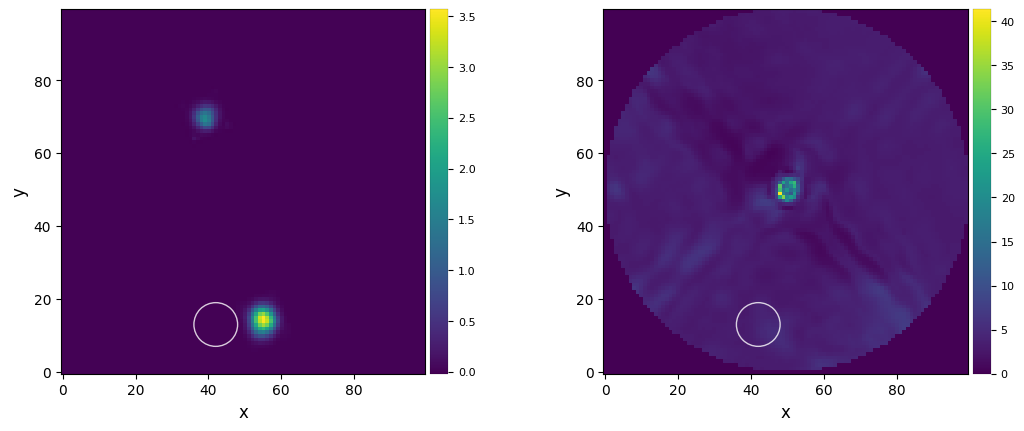

In [104]:
frame_id = 0
plot_frames((As[1]._matvec(x[1]).reshape(cube.shape)[frame_id]*stdev_frame, x[0].reshape(cube.shape)[frame_id]), circle=(location[1],location[0]))

In [105]:
np.max(As[1]._matvec(x[1]).reshape(cube.shape)*stdev_frame)

11.645475641738244

In [106]:
tmp = vip.preproc.cube_derotate(As[1]._matvec(x[1]).reshape(cube.shape), angles)

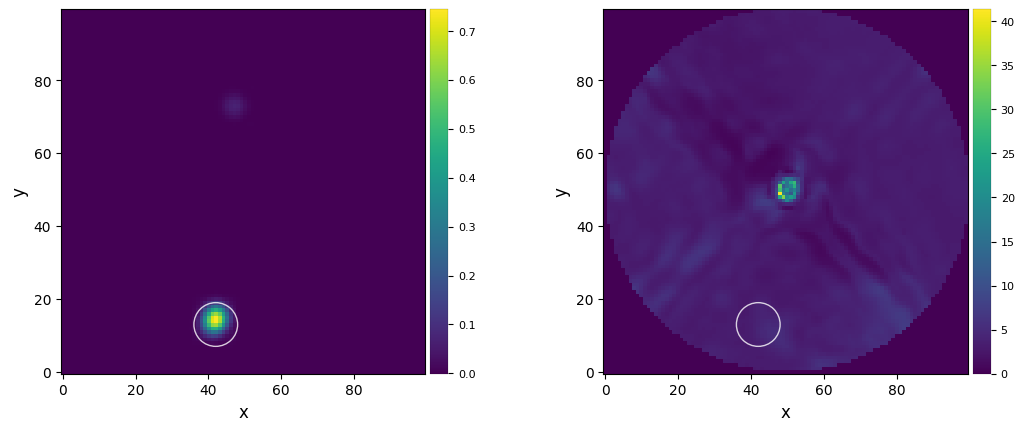

In [107]:
frame_id = 0
plot_frames((tmp[frame_id], x[0].reshape(cube.shape)[frame_id]), circle=(location[1],location[0]))

In [49]:
location[0][1],location[0][0]

(59.378590340349874, 61.17696873158132)

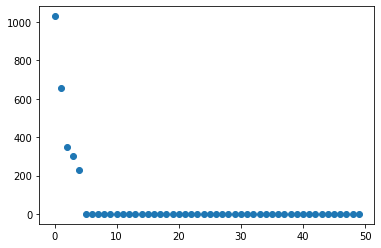

In [87]:
u,svals,vh = np.linalg.svd(x[0].reshape(m,n), full_matrices=False)
plt.plot(svals[:50], 'o')

In [88]:
#_, x = solver._compute_initial_guess(problem.A, b, (HTr, HTs))

In [89]:
(x[1].reshape(cube.shape[-2:])*stdev_frame).max() / 16

47.99640989264143

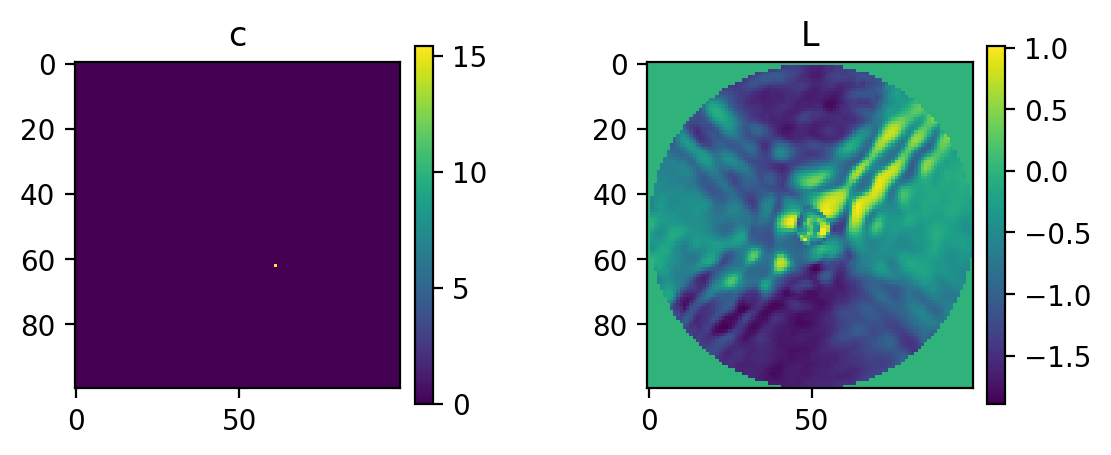

In [22]:
fig, axs = plt.subplots(1,2, dpi=200)
plt1 = axs[0].imshow(x[1].reshape(cube.shape[-2:]))
plt2 = axs[1].imshow(x[0].reshape(cube.shape)[40])
plt.colorbar(plt1, ax=axs[0],fraction=0.05, pad=0.04)
plt.colorbar(plt2, ax=axs[1],fraction=0.05, pad=0.04)
axs[0].title.set_text('c')
axs[1].title.set_text('L')
fig.subplots_adjust(wspace=0.6)
fig.show()

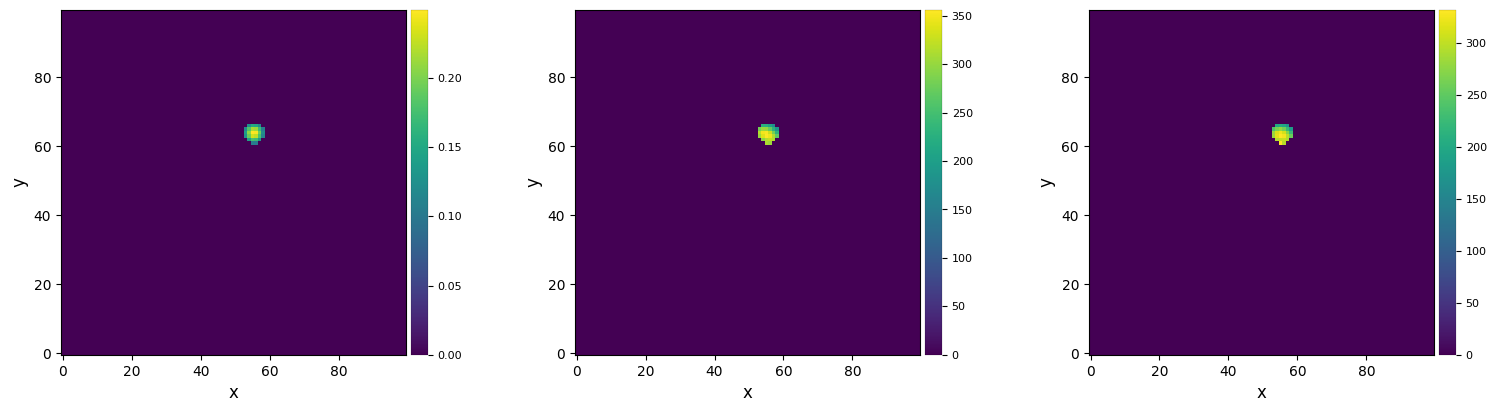

In [23]:
outs = trajectorlet.matvec(x[1]).reshape(cube.shape)
outl = x[0].reshape(cube.shape)*stdev_frame
outs_sup = np.abs(trajectorlet.matvec(x[1]).reshape(cube.shape)) >= 1e-1
outs_pl = outs * outs_sup
outl_pl = (outl +mean_frame )* outs_sup
cubefc_pl = cubefc * outs_sup
plot_frames((outs_pl[0],outl_pl[0],cubefc_pl[0] ))

In [44]:
outp_pl.shape

(2284298,)

In [92]:
P_omega = EntryWise((np.sum(outp_ind), m*n), outp_ind.flatten())
P_omegac = EntryWise((np.sum(~outp_ind), m*n), (~outp_ind.flatten()))

In [87]:
b2 = P_omega.matvec(cubefc.flatten())

In [54]:
HTr2 = FixedRank(10, (m,n))
problem2 = LinearProblem(P_omega, b2, HTr2)

In [55]:
solver2 = NIHT(logverbosity = 2, maxiter = 100, verbosity = 2, maxtime=2*60, minreldecrease = 1)
x2, opt_log2 = solver2.solve(problem2)

 iter		   obj. value	    grad. norm	     xdist
    1	+4.5801886971343446e+08	2.38433849e+04
    2	+2.5788112643334499e+08	3.02661154e+04
    3	+5.5406622722297323e+08	2.27103997e+04
    4	+2.5383333965546873e+08	3.32886235e+04
    5	+4.8091022288327855e+08	2.25314598e+04
    6	+2.5283486193361062e+08	3.10132302e+04
    7	+4.6876429036977160e+08	2.24871013e+04
    8	+2.5247441059418738e+08	3.06190885e+04
    9	+4.4829229876724792e+08	2.24710663e+04
   10	+2.5230193646481910e+08	2.99430225e+04
   11	+4.4081795476103199e+08	2.24633896e+04
   12	+2.5220809480577651e+08	2.96923544e+04
   13	+4.3550657481086934e+08	2.24592117e+04
   14	+2.5214954035854298e+08	2.95129319e+04
   15	+4.3237107904772878e+08	2.24566044e+04
   16	+2.5210983879571524e+08	2.94064986e+04
   17	+4.2967518281814426e+08	2.24548364e+04
   18	+2.5207893857486296e+08	2.93146783e+04
   19	+3.5549881321801883e+08	2.24534602e+04
   20	+2.5194186905137959e+08	2.66645387e+04
   21	+4.5379300189623719e+08	2.24473548e+04
   22	+2

In [93]:
P_omegac.shape

(5812, 2560000)

In [94]:
res = P_omegac.rmatvec(P_omegac.matvec(cubefc.flatten() - x2)).reshape(cube.shape)

In [99]:
flux

1440

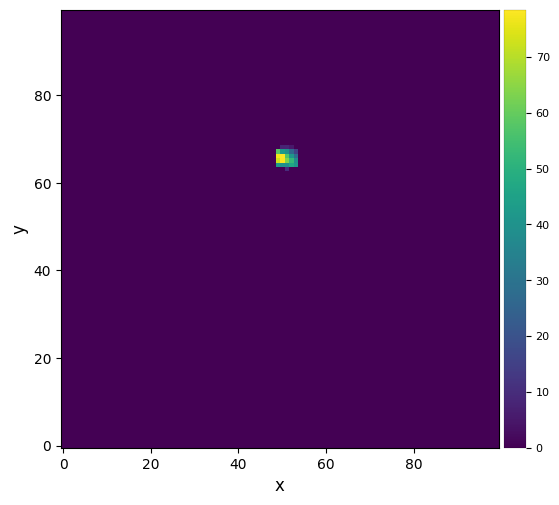

In [100]:
plot_frames(res[100])

In [90]:
P_omegac.matvec(cubefc.flatten() - x2)

ValueError: cannot reshape array of size 5812 into shape (2554188,)

In [70]:
P_omegac.matvec(cubefc.flatten() - x2)

ValueError: cannot reshape array of size 2560000 into shape (2554188,)

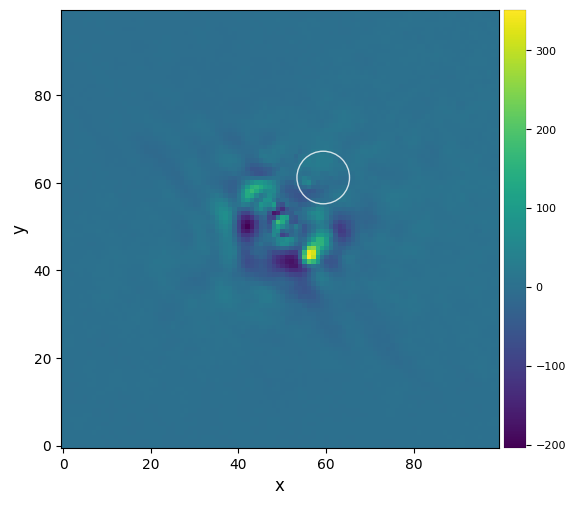

In [56]:
plot_frames(P_omegac cubefc[0] - x2.reshape(cube.shape)[0],circle=(location[0][1],location[0][0]))

In [57]:
a = trajectorlet.rmatvec(trajectorlet.matvec(mean_frame.flatten())).reshape(cube.shape[-2:])

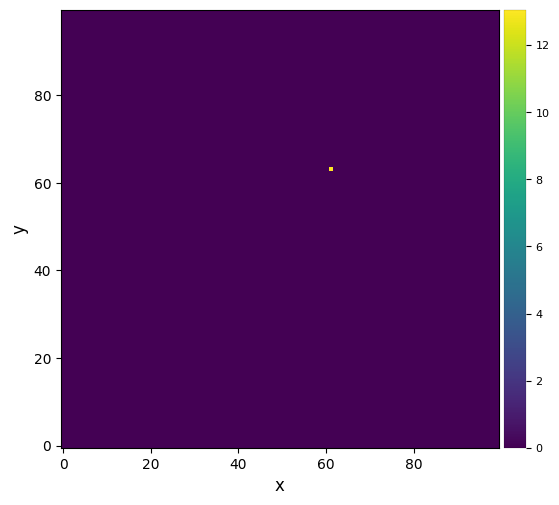

In [58]:
plot_frames(x[1].reshape(100,100))

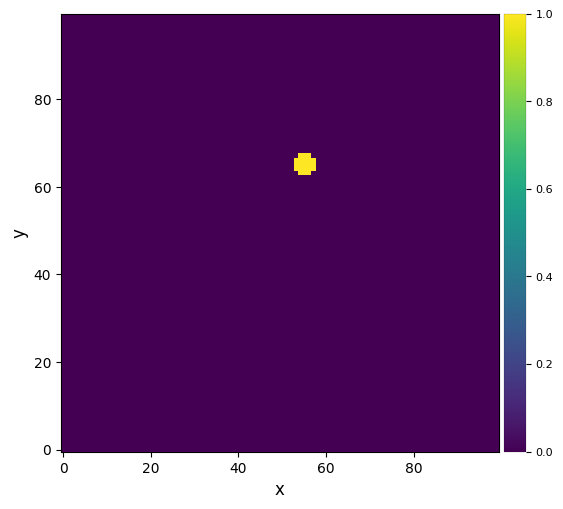

In [59]:
plot_frames(outp[0] >=1e-1)

In [212]:
np.linalg.norm(outp)

13.046858069703582

In [213]:
np.linalg.norm(b, ord=2)

1415.3444824619764

In [1]:
fig, axs = plt.subplots(2,2, dpi=200)

plt1 = axs[0,0].imshow(trajectorlet.matvec(x[1]).reshape(cube.shape)[40])
plt2 = axs[0,1].imshow(x[0].reshape(cube.shape)[40] * stdev_frame + mean_frame)
plt3 = axs[1,0].imshow(cube[40])
plt4 = axs[1,1].imshow(cube[40] - (x[0].reshape(cube.shape)[40] + trajectorlet.matvec(x[1]).reshape(cubefc.shape)[40]))

plt.colorbar(plt1, ax=axs[0,0],fraction=0.05, pad=0.04)
plt.colorbar(plt2, ax=axs[0,1],fraction=0.05, pad=0.04)
plt.colorbar(plt3, ax=axs[1,0],fraction=0.05, pad=0.04)
plt.colorbar(plt4, ax=axs[1,1],fraction=0.05, pad=0.04)

fig.show()

NameError: name 'plt' is not defined

In [215]:
out_s = trajectorlet.matvec(x[1]).reshape(cube.shape)
out_l = x[0].reshape(cube.shape)
out_s0 = out_s[0] #+ out_l[0]
out2 = (cube - out_l) * stdev_frame + mean_frame

In [216]:
out_sr = out_s0 * stdev_frame + mean_frame
out_s0_ind = np.abs(out_s[0])>=1e-2

In [217]:
(out2[0] * out_s0_ind).max()

520.9544782075491

In [218]:
tmp = (cube - out_l) * stdev_frame + mean_frame
np.linalg.norm(trajectorlet.rmatvec(tmp.flatten()))

2545585.6379065136

In [219]:
out2 = (cube - out_l) * stdev_frame + mean_frame

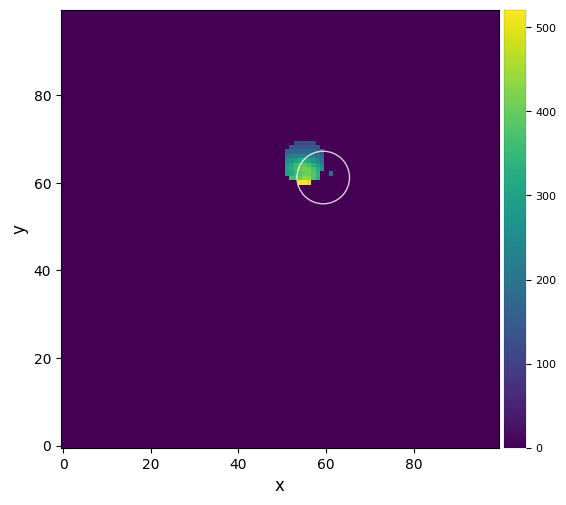

In [220]:
plot_frames(out2[0] * out_s0_ind, circle=(location[0][1],location[0][0]) )

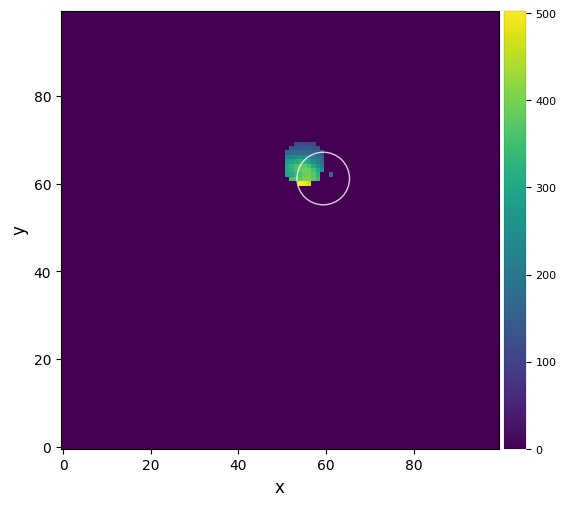

In [221]:
plot_frames(out_sr * out_s0_ind, circle=(location[0][1],location[0][0]) )

In [222]:
out_s = trajectorlet.matvec(x[1]).reshape(cube.shape)[0]
outs_mean = trajectorlet.matvec(mean_frame.flatten())

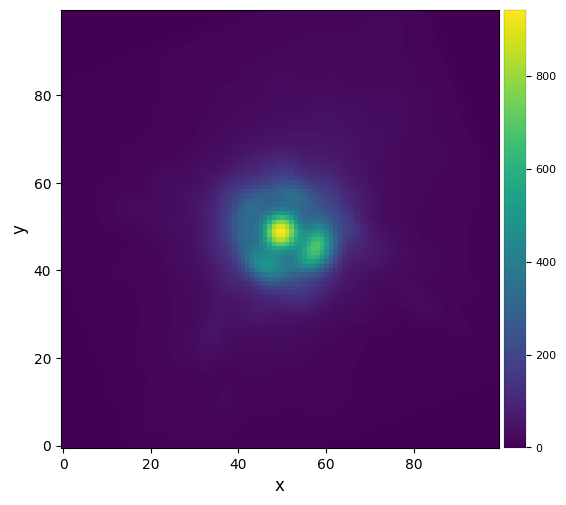

In [223]:
plot_frames(out_s + outs_mean.reshape(cube.shape)[0])

In [224]:
ind = np.argmax(out_s,axis=(1))

In [225]:
ind

array([48, 52, 48, 51, 47, 25, 45, 48, 50, 77, 24, 26, 12, 25, 90, 96, 16,
       57, 73, 75, 73, 75, 78, 74, 76, 74, 41, 43, 45, 47, 68, 41, 29, 31,
       63, 64, 41, 19, 62, 63, 64,  0, 29, 41,  5,  7,  9,  7,  8, 16, 18,
       20, 21, 25, 50, 51, 53, 50, 52, 52, 55, 55, 55, 55, 55, 55, 55, 55,
       55, 55, 55, 58, 58, 56, 57, 58, 60, 90, 91, 52, 90, 64, 58, 60, 69,
       86, 88, 47, 24, 26, 48, 57, 70, 73, 75, 70, 45, 81, 83, 64])

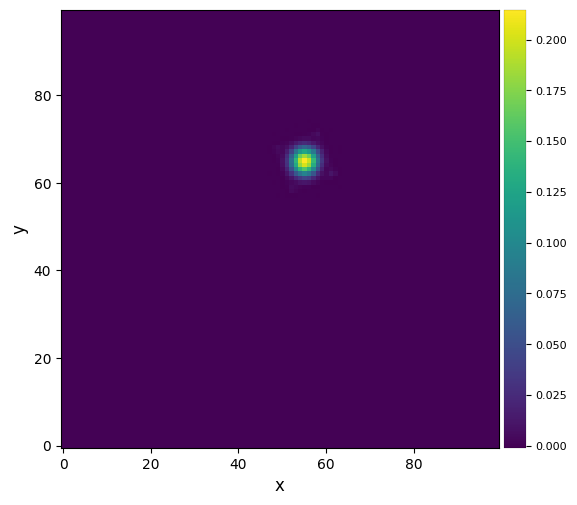

In [106]:
plot_frames(trajectorlet.matvec(x[1]).reshape(cube.shape)[0])

In [112]:
out_s = trajectorlet.matvec(x[1]).reshape(cube.shape)*stdev_frame + mean_frame
out_l = x[0].reshape(cube.shape)*stdev_frame + mean_frame

In [67]:
out_s[0][x[0]!=0]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 100 but corresponding boolean dimension is 2560000

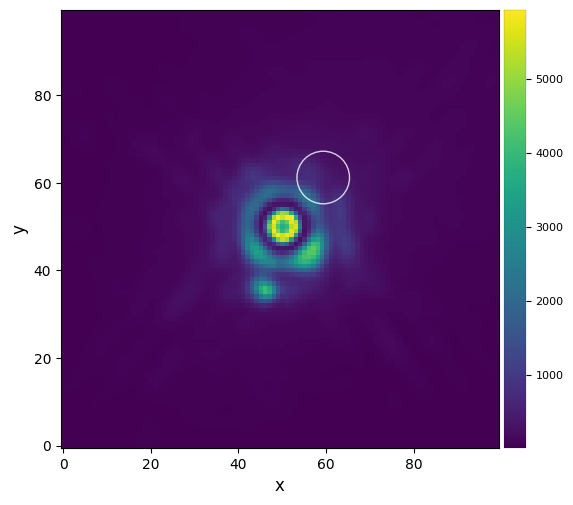

In [114]:
plot_frames((out_s)[0]+mean_frame,circle=(location[0][1],location[0][0]))

In [48]:
out1 = trajectorlet.matvec(x[1]).reshape(cube.shape) * stdev_frame

In [49]:
np.max(out1[0])

13.616787308341372

In [50]:
flux

720

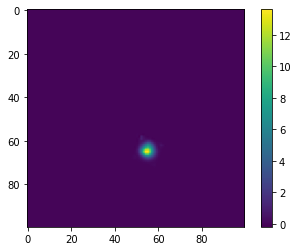

In [115]:
plt.imshow(out1[0])
plt.colorbar()

In [322]:
out1[x[1].reshape(cube.shape[-2:]) != 0]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 256 but corresponding boolean dimension is 100

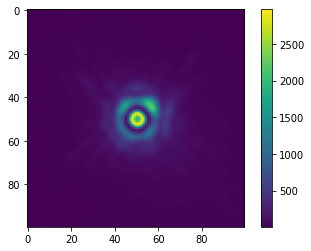

In [263]:
plt.imshow(x[1].reshape(cube.shape[-2:]) * stdev_frame / m + mean_frame)
plt.colorbar()

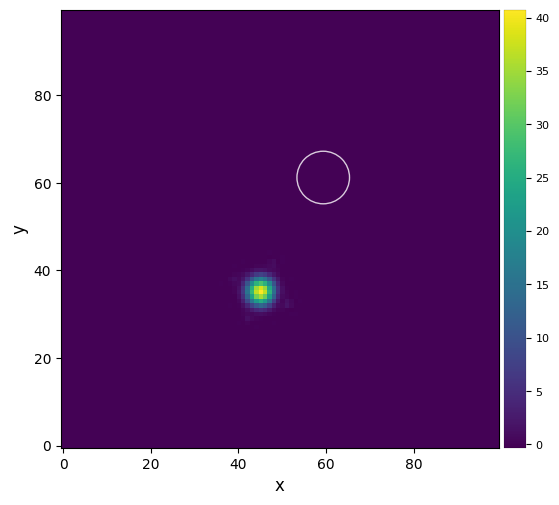

In [116]:
output_sparse = trajectorlet.matvec(x[1]).reshape(cube.shape) * stdev_frame + mean_frame
#
plot_frames(trajectorlet.matvec(x[1]).reshape(cube.shape)[0], circle=(location[0][1],location[0][0]) )

In [35]:
n*np.linalg.norm(trajectorlet.matvec(x[1])) / np.linalg.norm(x[1])

9992.20282743401

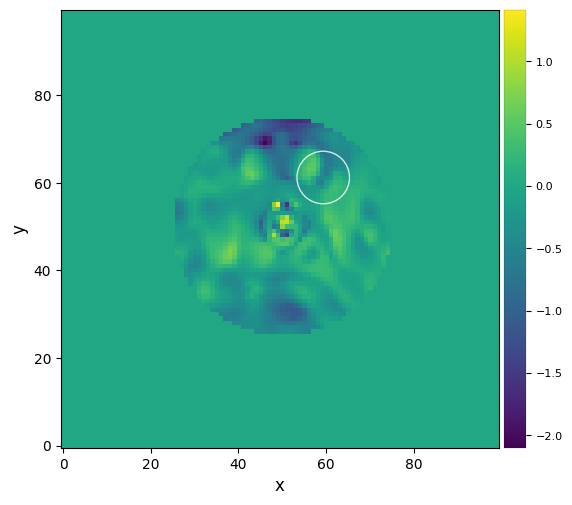

In [153]:
plot_frames(x[0].reshape(cubefc.shape).sum(axis=0), circle=(location[0][1],location[0][0]))

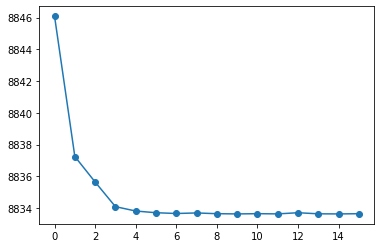

In [154]:
plt.plot(opt_log['iterations']['fx'], '-o')
plt.show()